In [101]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import re
import lxml
import bs4
# set some nicer defaults for matplotlib
from matplotlib import rcParams

#these colors come from colorbrewer2.org. Each is an RGB triplet
dark2_colors = [(0.10588235294117647, 0.6196078431372549, 0.4666666666666667),
                (0.8509803921568627, 0.37254901960784315, 0.00784313725490196),
                (0.4588235294117647, 0.4392156862745098, 0.7019607843137254),
                (0.9058823529411765, 0.1607843137254902, 0.5411764705882353),
                (0.4, 0.6509803921568628, 0.11764705882352941),
                (0.9019607843137255, 0.6705882352941176, 0.00784313725490196),
                (0.6509803921568628, 0.4627450980392157, 0.11372549019607843),
                (0.4, 0.4, 0.4)]

rcParams['figure.figsize'] = (10, 6)
rcParams['figure.dpi'] = 150
#rcParams['axes.prop_cycle'] = dark2_colors
rcParams['lines.linewidth'] = 2
rcParams['axes.grid'] = True
rcParams['axes.facecolor'] = '#eeeeee'
rcParams['font.size'] = 14
rcParams['patch.edgecolor'] = 'none'

## In this exercise we'll be scraping the poll data from RCP site and analyse it!

First we'll scrap the data

In [102]:
def get_poll_xml(poll_id):
    xml = requests.get("http://charts.realclearpolitics.com/charts/" + poll_id + ".xml").text
    return xml
#get_poll_xml("1171")
xml = get_poll_xml("1171")

In [103]:
def _strip(s):
    """This function removes non-letter characters from a word
    
    for example _strip('Hi there!') == 'Hi there'
    """
    return re.sub(r'[\W_]+', '', s)

In [109]:
#instead of pattern library I'm using beautiful soup as pattern doesn't support python 3
def plot_colors(xml):
    dom = bs4.BeautifulSoup(xml, "lxml")
    result = {}
    for graph in dom.find_all('graph'): 
            title = _strip(graph['title'])
            result[title] = graph['color']
    return result        
#print (result)

In [139]:
#cleaning the data is really important, make the array sizes equal and then convert it into a panda
#dataframe
def rcp_poll_data(xml):
    dom = bs4.BeautifulSoup(xml, "lxml")
    values = dom.find("series").find_all("value")
    value_list = []
    for value in values:
        value_list.append(value.text)
        #print (value_list)    
    presidents = {}
    graph = dom.find_all("graph")
    for g in graph:
        val = g.find_all("value")
        presidents[g["title"]] = [t.text if t.text else np.nan for t in val]
    result = pd.DataFrame({'Date':pd.to_datetime(value_list, errors = "ignore"), 
                           'Obama':presidents['Obama'],
                          'Romney':presidents['Romney']})
    result.Obama = result.Obama.astype(float)
    result.Romney = result.Romney.astype(float)
    return result

In [140]:
rcp_poll_data(xml).head()

,Date,Obama,Romney
0,2011-02-01,47.5,41.5
1,2011-02-02,47.5,41.5
2,2011-02-03,47.5,41.5
3,2011-02-04,47.5,41.5
4,2011-02-05,47.5,41.5


In [143]:
def poll_plot():
    data = rcp_poll_data(xml)
    colors = plot_colors(xml)
    
    #remove characters like apostrophes
    data = data.rename(columns = {c: _strip(c) for c in data.columns})
    
    #normalize poll numbers so they add to 100%    
    norm = data[list(colors.keys())].sum(axis = 1) / 100
    for c in colors.keys():
        data[c] /= norm
    
    for label, color in colors.items():
        plt.plot(data.Date, data[label], color = color, label = label)
    plt.xticks(rotation=70)
    plt.legend(loc='best')
    plt.xlabel("Date")
    plt.ylabel("Normalized Poll Percentage") 
rcp_poll_data(xml).dtypes

Date      datetime64[ns]
Obama            float64
Romney           float64
dtype: object

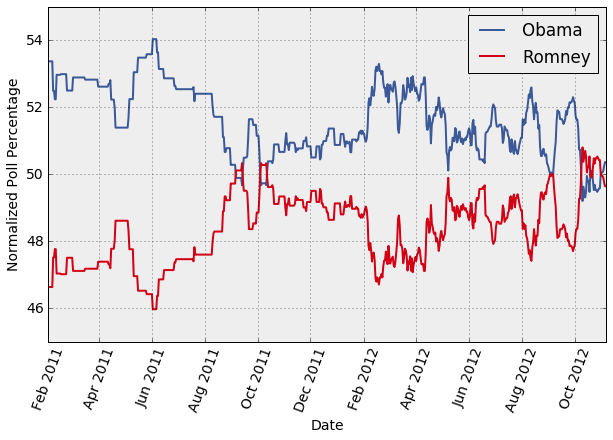

In [144]:
poll_plot()